In [17]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset

from PIL import Image
import matplotlib.pyplot as plt

class InvertPixelTransform(object):
    def __call__(self, image):
        # Ensure image is a PyTorch tensor and within the valid range [0, 1]
        if not isinstance(image, torch.Tensor):
            raise ValueError("Expected input image to be a PyTorch tensor.")
        if image.min() < 0 or image.max() > 1:
            raise ValueError("Image pixel values should be in the range [0, 1].")

        # Invert the pixel values (1 - value)
        inverted_image = 1 - image
        return inverted_image




# Data Loading and Transformation
transform_ori = v2.Compose([
    v2.ToTensor(),
])

transform_rot_invert = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(degrees=(45,45)),
    InvertPixelTransform(),
])

train_dataset_ori = datasets.MNIST(root='./data', train=True, download=True, transform=transform_ori)
train_dataset_rot_invert = datasets.MNIST(root='./data', train=True, download=True, transform=transform_rot_invert)

dataset = ConcatDataset(datasets=[train_dataset_ori, train_dataset_rot_invert])

# Visualize Original and Transformed Images
def show_images(original_image, transformed_image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original_image.squeeze(), cmap='gray')  # MNIST is grayscale
    axs[0].set_title("Original Image")

    axs[1].imshow(transformed_image.squeeze(), cmap='gray')
    axs[1].set_title("Rotated Inverted Image")

    plt.show()

# # Load a Sample Image
# sample_image, _ = train_dataset_ori[0]  # Load the first image (and its label)
#
# # Apply the Transformation
# inverted_sample, _ = train_dataset_rot_invert[0] # Clone to avoid modifying original

# Display Results
(sample_image, _), (inverted_sample, _) = dataset
show_images(sample_image, inverted_sample)


ValueError: not enough values to unpack (expected 2, got 1)

In [26]:
import os, sys
print(os.path.join(os.getcwd(), "..", "data"))
!ls ../data

/local/scratch/a/gong123/vaub-gp-pl-hydra/notebooks/../data
MNIST


In [4]:
import seaborn as sns
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
import open_clip
import os

class CLIPModule(nn.Module):

    def __init__(self, model_name, pretrained_dataset, device):
        super().__init__()

        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name,
            pretrained=pretrained_dataset,
            cache_dir=os.path.join(os.getcwd(), "..", "data"),
            device=device
        )

        self.device = device
        self.model = model
        self.preprocess = preprocess

    def get_dist_mat(self, batch, block_index_list=None):

        batch = batch.to(self.device)
        def batch_preprocess(image_batch, preprocess):
            to_pil_image = transforms.ToPILImage()
            image_stack = torch.concat([preprocess(to_pil_image(img)).unsqueeze(0) for img in image_batch])
            return image_stack

        def cosine_dist_matrix(batch1, batch2, dim=1, eps=1e-8):
            # Normalize the batches along the specified dimension
            batch1_norm = batch1 / torch.norm(batch1, dim=dim, keepdim=True).clamp(min=eps)
            batch2_norm = batch2 / torch.norm(batch2, dim=dim, keepdim=True).clamp(min=eps)

            # Calculate the cosine similarity matrix
            similarity_matrix = torch.mm(batch1_norm, batch2_norm.transpose(0, 1))
            return 1-similarity_matrix

        self.model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():

            dist_matrix_array = []
            for block_index in block_index_list:
                batch_block = batch[block_index]
                batch_processed = batch_preprocess(batch_block, self.preprocess).to(self.device)
                image_features_1 = self.model.encode_image(batch_processed)
                image_features_1 /= image_features_1.norm(dim=-1, keepdim=True)
                dist_matrix_array.append(cosine_dist_matrix(image_features_1, image_features_1, dim=-1))

        return  dist_matrix_array

    @staticmethod
    def plot_dist_matrix(similarity_score):

        similarity_np = similarity_score.detach().cpu().numpy()

        # Plot the heatmap
        plt.figure(figsize=(10, 8))  # Adjust figure size as needed
        sns.heatmap(similarity_np, annot=False, fmt=".2f", cmap="YlGnBu")
        plt.title(f"CLIP: Cosine Similarity Matrix (Heatmap)")
        plt.xlabel("Batch 2 Data Points")
        plt.ylabel("Batch 1 Data Points")
        plt.show()


def get_digits_image_batch(data_name, digit, num_selected=10, data_dir='../data'):

    # Define the transforms (convert to tensor and normalize)
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ])

    # Load the MNIST dataset
    trainset = data_name(root=data_dir, split='train', download=True, transform=transform)


    # Choose the digit you want to see
    digit_to_show = digit
    num_selected = num_selected

    # Find the indices of images with the chosen digit
    # indices = trainset.targets == digit_to_show
    # filtered_data = trainset.data[indices]
    filtered_data = torch.concat([image for image, label in trainset if label == int
    (digit)])
    rand_idx = torch.randperm(len(filtered_data))
    selected_data = filtered_data[rand_idx[:num_selected]]

    return  selected_data

#
# image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i, num_selected=10, data_dir="../data") for i in range(2)])
# clip_gp = CLIPModule('ViT-L-14', 'laion2b_s32b_b82k', 'cuda:2')
#
# dist_matrix_array = clip_gp.get_dist_mat(image_batch_mix)
# clip_gp.plot_dist_matrix(dist_matrix_array[0])


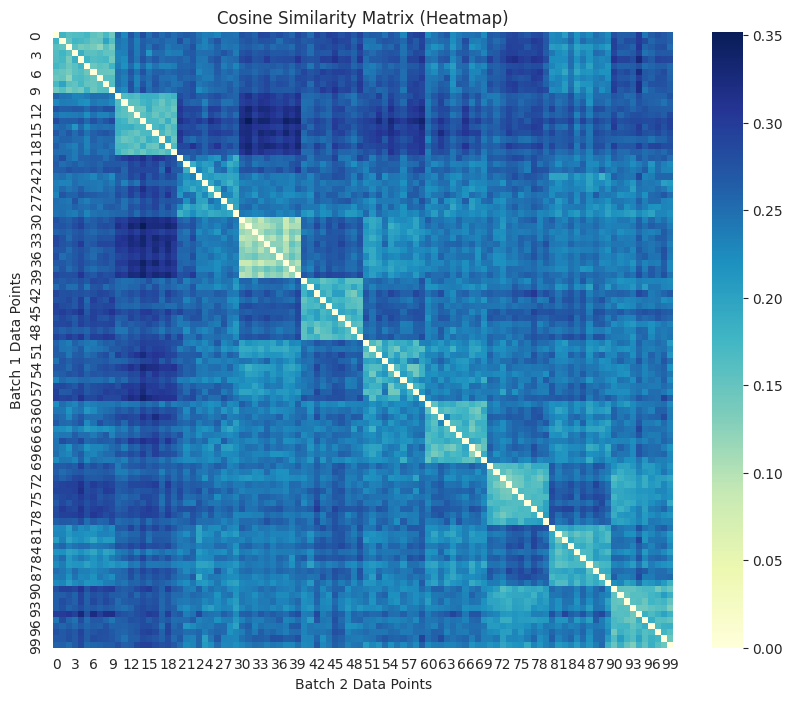

In [43]:
test_iter = 10

# image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i, num_selected=10, data_dir="../data") for i in range(2)])
clip_gp = CLIPModule('ViT-L-14', 'laion2b_s32b_b82k', 'cuda:2')

# dist_matrix_array = clip_gp.get_dist_mat(image_batch_mix)
# clip_gp.plot_dist_matrix(dist_matrix_array[0])

simliarity_score_list = []
for _ in range(test_iter):
    image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i,) for i in range(10)])
    # print(image_batch_mix.size())
    simliarity_score_list.append(clip_gp.get_dist_mat(image_batch_mix)[0])

simliarity_score_sum = sum(simliarity_score_list)/len(simliarity_score_list)
simliarity_score_sum_np = simliarity_score_sum.detach().cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(simliarity_score_sum_np, annot=False, fmt=".2f", cmap="YlGnBu")
plt.title(f"Cosine Similarity Matrix (Heatmap)")
plt.xlabel("Batch 2 Data Points")
plt.ylabel("Batch 1 Data Points")
plt.show()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


/local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


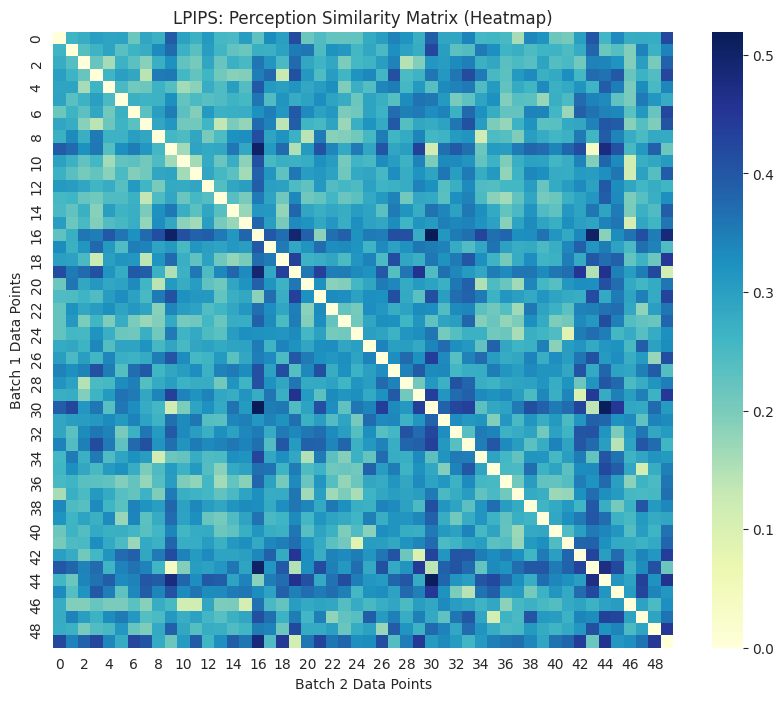

In [71]:
import lpips

class LPIPSModule(nn.Module):

    def __init__(self, net_name, device):

        super().__init__()
        self.loss_fn = lpips.LPIPS(net=net_name).to(device)

        self.device = device

    def get_dist_mat(self, batch, block_index_list=None):

        batch = batch.to(self.device)
        if block_index_list is None:
            block_index_list = [range(len(batch))]

        def lpips_dist_matrix(batch1, batch2):

            similarity_matrix = []
            for batch in batch2:
                similarity_matrix.append(self.loss_fn.forward(batch, batch1).squeeze().unsqueeze(0))
                # Calculate the cosine similarity matrix
            return torch.concat(similarity_matrix)

        with torch.no_grad(), torch.cuda.amp.autocast():
            if len(batch.size())==3:
                batch = batch.unsqueeze(1)

            dist_matrix_array = []
            for block_index in block_index_list:
                batch_block = batch[block_index]
                dist_matrix_array.append(lpips_dist_matrix(batch_block, batch_block))

        return  dist_matrix_array


    @staticmethod
    def plot_dist_matrix(similarity_score):

        similarity_np = similarity_score.detach().cpu().numpy()

        # Plot the heatmap
        plt.figure(figsize=(10, 8))  # Adjust figure size as needed
        sns.heatmap(similarity_np, annot=False, fmt=".2f", cmap="YlGnBu")
        plt.title(f"LPIPS: Perception Similarity Matrix (Heatmap)")
        plt.xlabel("Batch 2 Data Points")
        plt.ylabel("Batch 1 Data Points")
        plt.show()


block_index_list = torch.split(torch.randperm(100), 50)
image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i, num_selected=10, data_dir="../data") for i in range(10)])
lpips_gp = LPIPSModule(net_name='vgg', device='cuda:1')

dist_matrix_array = lpips_gp.get_dist_mat(image_batch_mix, block_index_list)
lpips_gp.plot_dist_matrix(dist_matrix_array[0])

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


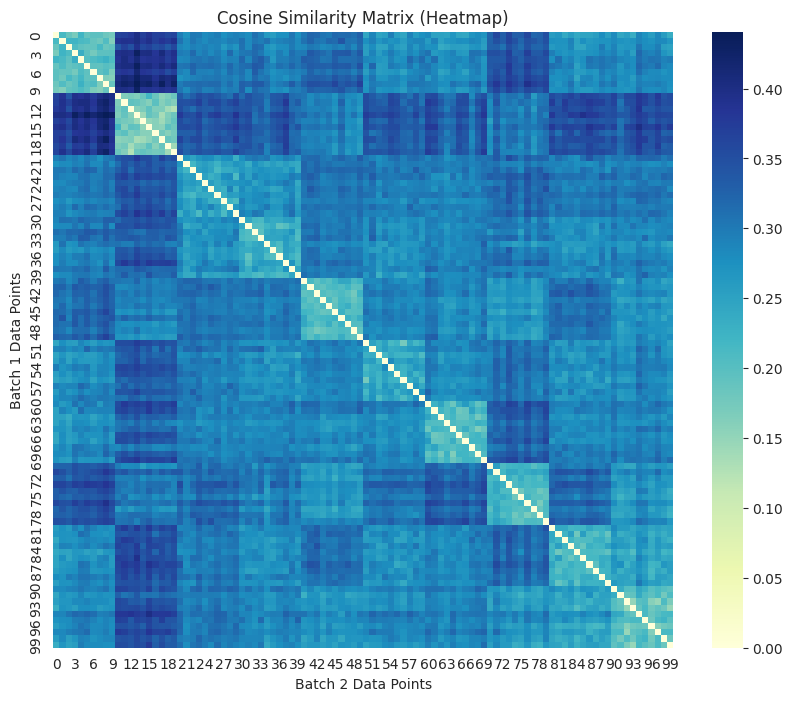

In [64]:
test_iter = 10

# image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i, num_selected=10, data_dir="../data") for i in range(2)])
lpips_gp = LPIPSModule(net_name='vgg', device='cuda:1')

# dist_matrix_array = clip_gp.get_dist_mat(image_batch_mix)
# clip_gp.plot_dist_matrix(dist_matrix_array[0])

simliarity_score_list = []
for _ in range(test_iter):
    image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.MNIST, digit=i,) for i in range(10)])
    # print(image_batch_mix.size())
    simliarity_score_list.append(lpips_gp.get_dist_mat(image_batch_mix)[0])

simliarity_score_sum = sum(simliarity_score_list)/len(simliarity_score_list)
simliarity_score_sum_np = simliarity_score_sum.detach().cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(simliarity_score_sum_np, annot=False, fmt=".2f", cmap="YlGnBu")
plt.title(f"Cosine Similarity Matrix (Heatmap)")
plt.xlabel("Batch 2 Data Points")
plt.ylabel("Batch 1 Data Points")
plt.show()

In [70]:
block_index_list = torch.split(torch.randperm(100), split_size_or_sections=50)
print(block_index_list)

(tensor([20, 99, 35, 37, 51, 45, 72, 59, 25, 63, 68, 48, 67, 26, 95, 27, 42, 78,
        93, 39, 44, 94, 81, 75, 29, 77, 70, 73, 88, 34, 36, 18, 43,  9, 62, 91,
        49, 57, 80, 66, 38, 47, 74,  0, 65,  2, 23, 53,  7, 82]), tensor([52, 17, 33, 54, 24, 98, 11, 14, 50,  5, 69, 85, 56,  6, 21, 40, 15, 12,
        87, 61, 64, 60,  1, 13, 84, 89, 58, 55, 16, 83, 76, 30,  4,  3, 79, 31,
        41, 22, 96, 97, 28, 46, 10, 90, 32, 86, 19,  8, 92, 71]))


In [79]:
A = torch.rand(size=(10,))

In [80]:
print(A)

tensor([0.6621, 0.3625, 0.0023, 0.4610, 0.6129, 0.3546, 0.8268, 0.4288, 0.4338,
        0.4714])


In [82]:
print(torch.norm(A, p=float('inf')))

tensor(0.8268)


In [3]:
import os, sys
import torch
sys.path.append(os.path.join(os.getcwd(), ".."))
from src.models.components.vae_cnn import CNN_VAE

input_x = torch.rand(size=(10, 1, 32, 32))
net = CNN_VAE(latent_height=16, latent_width=16)
output = net(input_x)
print([out.size() for out in output])
print(output)


[torch.Size([10, 1, 32, 32]), torch.Size([10, 1, 16, 16]), torch.Size([10, 256]), torch.Size([10, 256])]
(tensor([[[[0.5623, 0.5195, 0.6916,  ..., 0.6594, 0.5590, 0.5224],
          [0.4981, 0.5390, 0.5919,  ..., 0.6475, 0.5759, 0.4538],
          [0.5384, 0.5375, 0.5375,  ..., 0.3794, 0.5013, 0.5118],
          ...,
          [0.5258, 0.6905, 0.4069,  ..., 0.7159, 0.6731, 0.5310],
          [0.4420, 0.4839, 0.4803,  ..., 0.4894, 0.5316, 0.4905],
          [0.5624, 0.5837, 0.6190,  ..., 0.7375, 0.5487, 0.4670]]],


        [[[0.5603, 0.5108, 0.6819,  ..., 0.4864, 0.6253, 0.5594],
          [0.5295, 0.5515, 0.5903,  ..., 0.5537, 0.5378, 0.4946],
          [0.5518, 0.5352, 0.4927,  ..., 0.4162, 0.5079, 0.5153],
          ...,
          [0.5517, 0.6232, 0.4731,  ..., 0.6086, 0.4970, 0.5605],
          [0.4797, 0.4799, 0.5559,  ..., 0.4781, 0.5127, 0.4781],
          [0.3706, 0.6075, 0.5645,  ..., 0.5834, 0.5824, 0.5277]]],


        [[[0.5604, 0.4609, 0.7225,  ..., 0.4758, 0.6559, 0.5404]

In [26]:
import sys

import torch
import torch.nn as nn
import lpips
from torchvision import transforms
import open_clip
import os

from typing import Union


class CLIPModule(nn.Module):

    def __init__(self, model_name, pretrained_dataset, device):
        super().__init__()

        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name,
            pretrained=pretrained_dataset,
            cache_dir=os.path.join(os.getcwd(), "..", "data"),
            device=device
        )

        self.device = device
        self.model = model
        self.preprocess = preprocess

    def to_device(self, device):

        self.device = device
        self.model = self.model.to(device)

    def get_dist_mat(self, batch, block_index_list=None):

        batch = batch.to(self.device)
        def batch_preprocess(image_batch, preprocess):
            to_pil_image = transforms.ToPILImage()
            image_stack = torch.concat([preprocess(to_pil_image(img)).unsqueeze(0) for img in image_batch])
            return image_stack

        def cosine_dist_matrix(batch1, batch2, dim=1, eps=1e-8):
            # Normalize the batches along the specified dimension
            batch1_norm = batch1 / torch.norm(batch1, dim=dim, keepdim=True).clamp(min=eps)
            batch2_norm = batch2 / torch.norm(batch2, dim=dim, keepdim=True).clamp(min=eps)

            # Calculate the cosine similarity matrix
            similarity_matrix = torch.mm(batch1_norm, batch2_norm.transpose(0, 1))
            return 1-similarity_matrix

        self.model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():

            dist_matrix_array = []
            for block_index in block_index_list:
                batch_block = batch[block_index]
                batch_processed = batch_preprocess(batch_block, self.preprocess).to(self.device)
                image_features_1 = self.model.encode_image(batch_processed).detach()
                image_features_1 /= image_features_1.norm(dim=-1, keepdim=True)
                dist_matrix_array.append(cosine_dist_matrix(image_features_1, image_features_1, dim=-1))

        return dist_matrix_array


class LPIPSModule(nn.Module):

    def __init__(self, net_name, device):

        super().__init__()
        self.loss_fn = lpips.LPIPS(net=net_name).to(device)

        self.device = device

    def to_device(self, device):

        self.device = device
        self.loss_fn = self.loss_fn.to(device)

    def get_dist_mat(self, batch, block_index_list=None):

        batch = batch.to(self.device)
        if block_index_list is None:
            block_index_list = [range(len(batch))]

        def lpips_dist_matrix(batch1, batch2):
            # print(f"batch 1 is in device {batch1.device}")
            # print(f"batch 2 is in device {batch2.device}")
            similarity_matrix = []
            for batch in batch2:
                similarity_matrix.append(self.loss_fn.forward(batch, batch1).squeeze().unsqueeze(0).detach())
                # Calculate the cosine similarity matrix
            return torch.concat(similarity_matrix)

        with torch.no_grad(), torch.cuda.amp.autocast():
            if len(batch.size())==3:
                batch = batch.unsqueeze(1)

            dist_matrix_array = []
            for block_index in block_index_list:
                batch_block = batch[block_index]
                dist_matrix_array.append(lpips_dist_matrix(batch_block, batch_block))

        return dist_matrix_array


class GPModule(nn.Module):

    def __init__(self, metric_name, device, **kwargs):
        super().__init__()

        # print(f"GP module on device {device}")

        if metric_name == "CLIP":
            self.dist_module = CLIPModule(
                model_name=kwargs.get("model_name"),
                pretrained_dataset=kwargs.get("pretrained_dataset"),
                device=device,
            )
        elif metric_name == "LPIPS":
            self.dist_module = LPIPSModule(
                net_name=kwargs.get("net_name"),
                device=device,
            )
        else:
            sys.exit("Wrong metric for GP module")

        self.device = device

    def to_device(self, device):
        self.dist_module.to_device(device)

    def get_euc_dist_mat(self, z, block_index_list, p=2):

        dist_mat_list = []
        for block_index in block_index_list:
            if len(z[block_index].size()) > 2:
                z_block = z[block_index].view(len(z[block_index]), -1)
            else:
                z_block = z[block_index]

            # Expand dimensions to create pairs of vectors
            z1 = z_block.unsqueeze(1)  # (batch_size, 1, num_features)
            z2 = z_block.unsqueeze(0)  # (1, batch_size, num_features)

            # Calculate squared differences between each pair
            squared_diffs = (z1 - z2).pow(p)

            # Sum along the feature dimension (last dimension) to get squared distances
            squared_dists = squared_diffs.mean(dim=-1)

            # Take the square root to get Euclidean distances
            # dist_mat_list.append(squared_dists**(1/p))
            dist_mat_list.append(squared_dists)


        return dist_mat_list

    def compute_gp_loss(self, x_list: list, z_list: list, block_size: Union[int, None] = None) -> torch.Tensor:

        batch_size = len(x_list[0])
        if block_size is None:
            block_size = batch_size

        block_index_list = torch.split(torch.randperm(batch_size),
                                       split_size_or_sections=block_size)
        block_index_list = [block.to(self.device) for block in block_index_list]
        tot_gp_loss = 0

        for x, z in zip(x_list, z_list):
            # print(x.device, z.device)
            dist_mat_x_list = self.dist_module.get_dist_mat(x, block_index_list)
            # print(dist_mat_x_list[0].dtype)
            dist_mat_z_list = self.get_euc_dist_mat(z, block_index_list)
            # print(dist_mat_z_list[0].dtype)
            # [dist_mat_x.to(dist_mat_z_list[0].dtype) for dist_mat_x in dist_mat_x_list]

            for dist_mat_x, dist_mat_z in zip(dist_mat_x_list, dist_mat_z_list):
                # print(dist_mat_x.size(), dist_mat_x.max())
                dist_mat_x /= dist_mat_x.max()

                tot_gp_loss += ((dist_mat_x-dist_mat_z)**2).sum()/(len(dist_mat_x)**2)
                print(tot_gp_loss)

        return tot_gp_loss


metric_name = "LPIPS"
device = "cuda:2"
net_name = "alex"

gp_module = GPModule(metric_name, device, net_name=net_name)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /local/scratch/a/gong123/anaconda3/envs/vaub-gp/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)

class ConvFCModel(nn.Module):
    def __init__(self):
        super(ConvFCModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)  # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 16x16 -> 8x8

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 256)  # Flatten and reduce dimensionality
        self.fc2 = nn.Linear(256, 1 * 16 * 16)  # Map to output size

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolutional layer
        x = F.relu(self.conv2(x))  # Apply second convolutional layer

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer

        x = x.view(x.size(0), 1, 16, 16)  # Reshape to the desired output size
        return x

src_vae = ConvFCModel().to(device)
tgt_vae = ConvFCModel().to(device)

for iter_idx in range(1):
    print(f"\nStart Epoch {iter_idx:02d}")

    x1 = torch.randn(size=(16, 1, 32, 32)).to(device)
    x2 = torch.randn(size=(16, 1, 32, 32)).to(device)

    z1 = src_vae(x1)
    z2 = tgt_vae(x2)

    print(x1.size(), z1.size())

    print(z1.cpu().detach().max(), z2.cpu().detach().max())

    gp_loss = gp_module.compute_gp_loss(
        [x1.view((x1.shape[0], 1, 32, 32)), x2.view((x1.shape[0], 1, 32, 32))],
        [z1.view((z1.shape[0], -1)), z2.view((z2.shape[0], -1))],
        block_size=8,
    )

    # for name, param in src_vae.named_parameters():
    #     if param.grad is not None:
    #         print("Before Yes")
    #         break

    print(gp_loss)
    gp_loss.backward()

    for name, param in src_vae.named_parameters():
        if param.grad is not None:
            print(name, param.grad.abs())
            # break


# z_list = [torch.randn(size=(16, 1, 16, 16), requires_grad=True).to(device) for _ in range(2)]
# loss = gp_module.compute_gp_loss(x_list, z_list, block_size=8)
#
# loss.backward()
#
# print(z_list[0].grad)


Start Epoch 00
torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 16, 16])
tensor(0.1418) tensor(0.1526)
tensor(0.4659, device='cuda:2', grad_fn=<AddBackward0>)
tensor(0.8482, device='cuda:2', grad_fn=<AddBackward0>)
tensor(1.2941, device='cuda:2', grad_fn=<AddBackward0>)
tensor(1.5942, device='cuda:2', grad_fn=<AddBackward0>)
tensor(1.5942, device='cuda:2', grad_fn=<AddBackward0>)
conv1.weight tensor([[[[2.9171e-05, 2.6725e-05, 2.2816e-04],
          [2.4105e-04, 2.2697e-04, 3.8021e-04],
          [3.2664e-04, 1.1639e-04, 2.0270e-04]]],


        [[[7.7196e-06, 1.7199e-06, 1.7394e-04],
          [1.6079e-04, 1.1860e-04, 2.8149e-04],
          [1.8448e-04, 4.8936e-05, 6.7266e-05]]],


        [[[1.5379e-04, 2.4133e-04, 2.5514e-04],
          [2.2130e-04, 2.1834e-05, 1.6093e-04],
          [1.8539e-04, 1.9606e-04, 4.6372e-04]]],


        [[[1.0590e-04, 2.1493e-04, 2.9171e-04],
          [1.0094e-04, 2.9429e-04, 3.6071e-04],
          [8.8882e-05, 1.7307e-04, 3.6038e-05]]],


        [[[1.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvFCModel(nn.Module):
    def __init__(self):
        super(ConvFCModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)  # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 16x16 -> 8x8

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 256)  # Flatten and reduce dimensionality
        self.fc2 = nn.Linear(256, 1 * 16 * 16)  # Map to output size

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolutional layer
        x = F.relu(self.conv2(x))  # Apply second convolutional layer

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer

        x = x.view(x.size(0), 1, 16, 16)  # Reshape to the desired output size
        return x

src_vae = ConvFCModel().to(device)
tgt_vae = ConvFCModel().to(device)

for iter_idx in range(1):
    print(f"\nStart Epoch {iter_idx:02d}")

    x1 = torch.randn(size=(16, 1, 32, 32)).to(device)
    x2 = torch.randn(size=(16, 1, 32, 32)).to(device)

    z1 = src_vae(x1)
    z2 = tgt_vae(x2)

    print(x1.size(), z1.size())

    print(z1.cpu().detach().max(), z2.cpu().detach().max())

    gp_loss = gp_module.compute_gp_loss(
        [x1.view((x1.shape[0], 1, 32, 32)), x2.view((x1.shape[0], 1, 32, 32))],
        [z1.view((z1.shape[0], -1)), z2.view((z2.shape[0], -1))],
        block_size=8,
    )

    for name, param in src_vae.named_parameters():
        if param.grad is not None:
            print("Before Yes")
            break

    print(gp_loss)
    gp_loss.backward()

    for name, param in src_vae.named_parameters():
        if param.grad is not None:
            print(f"After Yes with value {param.grad.abs().max()}")
            break


# z_list = [torch.randn(size=(16, 1, 16, 16), requires_grad=True).to(device) for _ in range(2)]
# loss = gp_module.compute_gp_loss(x_list, z_list, block_size=8)
#
# loss.backward()
#


Start Epoch 00
torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 16, 16])
tensor(0.1333) tensor(0.1531)
tensor(1.2702, device='cuda:2', grad_fn=<AddBackward0>)
After Yes with value nan


In [5]:
simliarity_score_list = []
for _ in range(test_iter):
    image_batch_mix = torch.concat([get_digits_image_batch(data_name=datasets.SVHN, digit=i,) for i in range(10)])
    # print(image_batch_mix.size())
    simliarity_score_list.append(clip_gp.get_dist_mat(image_batch_mix)[0])

simliarity_score_sum = sum(simliarity_score_list)/len(simliarity_score_list)
simliarity_score_sum_np = simliarity_score_sum.detach().cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(simliarity_score_sum_np, annot=False, fmt=".2f", cmap="YlGnBu")
plt.title(f"Cosine Similarity Matrix (Heatmap)")
plt.xlabel("Batch 2 Data Points")
plt.ylabel("Batch 1 Data Points")
plt.show()

Using downloaded and verified file: ../data/train_32x32.mat


TypeError: only length-1 arrays can be converted to Python scalars

In [22]:
import torch
import torchvision
from torchvision import transforms
import random
import matplotlib.pyplot as plt

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
train_dataset = torchvision.datasets.SVHN(root='../data', split='train', transform=transform)

def get_digits_image_batch(dataset, digit, num_selected=500, plot=False):

    # Get indices of images with label 1
    indices_digit_1 = [i for i, (_, label) in enumerate(dataset) if label == int(digit)]

    # Randomly select 10 indices
    selected_indices = random.sample(indices_digit_1, num_selected)

    # Get the selected images and labels
    selected_images = [train_dataset[i][0] for i in selected_indices]
    # selected_labels = [train_dataset[i][1] for i in selected_indices]

    if plot:
        # Plot the selected images
        for i, image in enumerate(selected_images):
            # Unnormalize if needed
            image = image * 0.5 + 0.5

            plt.subplot(2, 5, i+1)  # Create a 2x5 grid of subplots
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"Digit 1")
            plt.axis('off')
        plt.show()

    return selected_images


In [23]:
all_digits_list = [get_digits_image_batch(train_dataset, idx) for idx in range(10)]

In [27]:
import os, sys
import torch
sys.path.append(os.path.join(os.getcwd(), ".."))
from src.models.components.gp_model import CLIPModule
from src.utils.utils_visual import plot_dist_matrix

simliarity_score_list = []
for _ in range(10):
    selected_idx = torch.randperm(500)[:10]
    all_digits_mix = [torch.stack(digits, dim=0)[selected_idx] for digits in all_digits_list]
    test_iter = 1
    clip_gp = CLIPModule('ViT-L-14', 'laion2b_s32b_b82k', 'cuda:2')
    dist_matrix_array = clip_gp.get_dist_mat(torch.concat(all_digits_mix), [range(100)])
    simliarity_score_list.append(dist_matrix_array[0])

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

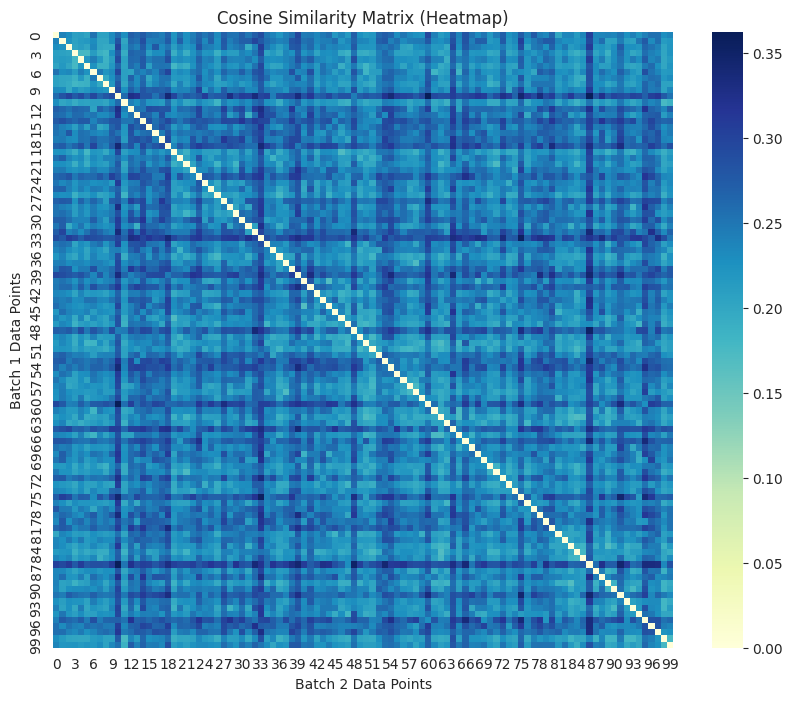

In [28]:
import seaborn as sns

simliarity_score_sum = sum(simliarity_score_list)/len(simliarity_score_list)
simliarity_score_sum_np = simliarity_score_sum.detach().cpu().numpy()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(simliarity_score_sum_np, annot=False, fmt=".2f", cmap="YlGnBu")
plt.title(f"Cosine Similarity Matrix (Heatmap)")
plt.xlabel("Batch 2 Data Points")
plt.ylabel("Batch 1 Data Points")
plt.show()

In [19]:
print(torch.stack(all_digits_list[0]).size())
print(torch.concat(all_digits_mix).size())

torch.Size([10, 3, 32, 32])
torch.Size([300, 32, 32])


In [28]:
import torch
A = torch.rand(size=(10, 20))

In [29]:
print(A.sum(dim=1).size())

torch.Size([10])


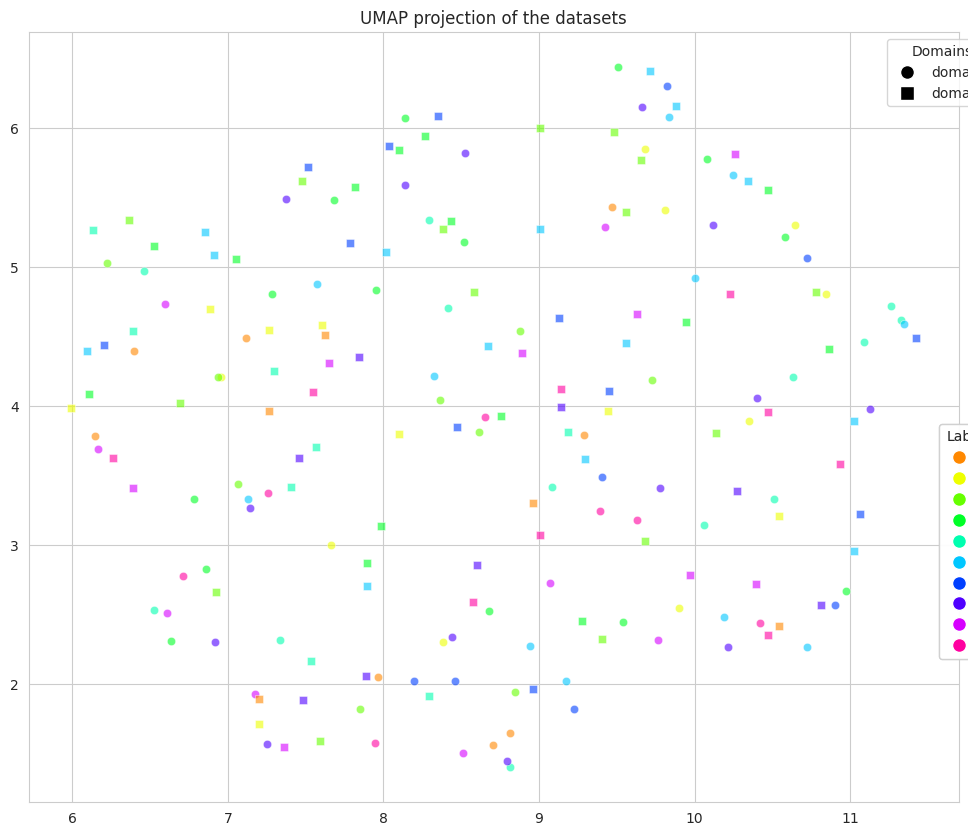

In [2]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Function to plot UMAP with different markers for domains and different colors for labels
def plot_umap(data1, labels1, domain1, data2, labels2, domain2):

    # Combine the datasets
    data = np.vstack((data1, data2))
    labels = np.concatenate((labels1, labels2))
    domains = np.concatenate((domain1, domain2))

    # Fit and transform the data using UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(data)

    # Create a DataFrame for easier handling
    df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df['label'] = labels
    df['domain'] = domains

    # Define markers and colors
    markers = {'domain1': 'o', 'domain2': 's'}
    unique_labels = np.unique(labels)
    palette = sns.color_palette("hsv", len(unique_labels))
    color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 10))
    for domain in markers:
        for label in unique_labels:
            subset = df[(df['domain'] == domain) & (df['label'] == label)]
            ax.scatter(subset['UMAP1'], subset['UMAP2'], c=[color_map[label]], label=f'{domain}-{label}', marker=markers[domain], alpha=0.6, edgecolors='w', linewidth=0.5)

    # Add a legend for domains only
    domain_handles = [plt.Line2D([0], [0], marker=markers[domain], color='w', markerfacecolor='k', markersize=10, label=domain) for domain in markers]
    domain_legend = ax.legend(handles=domain_handles, title='Domains', loc='best', bbox_to_anchor=(1.05, 1), ncol=1)

    # Add a legend for labels
    label_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10, label=label) for label in unique_labels]
    label_legend = ax.legend(handles=label_handles, title='Labels', loc='upper right', bbox_to_anchor=(1.05, 0.5), ncol=1)

    # Add the legends to the plot
    ax.add_artist(domain_legend)
    ax.add_artist(label_legend)

    ax.set_title('UMAP projection of the datasets')
    plt.show()

# Example usage with dummy data
data1 = np.random.rand(100, 10)
labels1 = np.random.randint(0, 10, 100)
domain1 = np.array(['domain1'] * 100)

data2 = np.random.rand(100, 10)
labels2 = np.random.randint(0, 10, 100)
domain2 = np.array(['domain2'] * 100)

plot_umap(data1, labels1, domain1, data2, labels2, domain2)

/tmp/ipykernel_2780511/1391583210.py:55: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  axes[0].legend(by_label.values(), by_label.keys(), title='Domain-Label', loc='best', bbox_to_anchor=(1.05, 1))


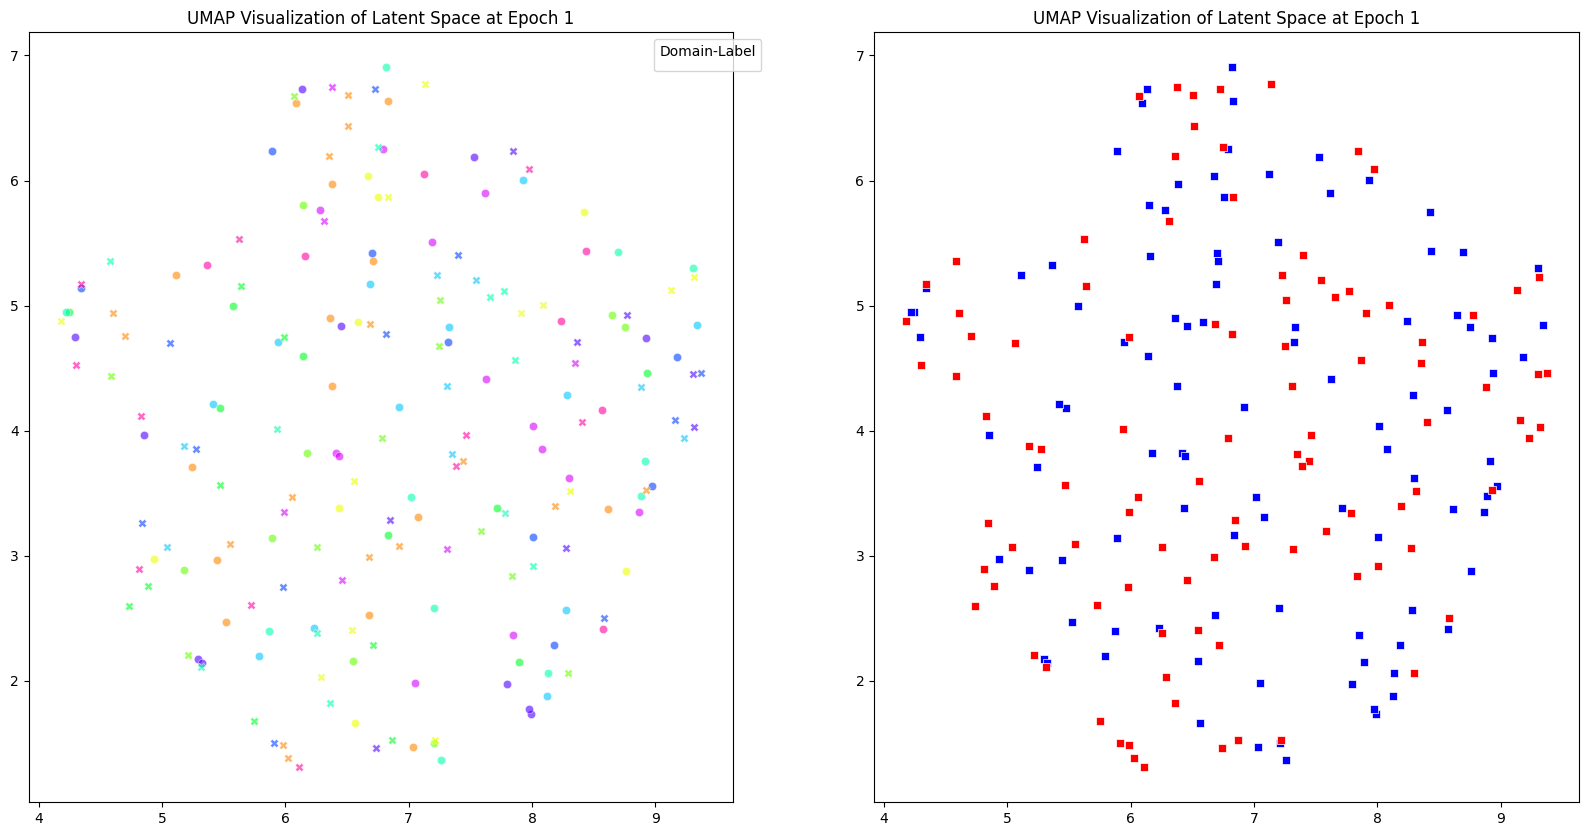

In [9]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def display_umap_for_latent(axes, epoch, z1, z2, label_1, label_2):

    # Combine the datasets
    data = np.vstack((z1, z2))
    labels = np.concatenate((label_1, label_2))
    domains = np.concatenate((['domain1'] * len(z1), ['domain2'] * len(z2)))

    # Fit and transform the data using UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(data)

    # Create a DataFrame for easier handling
    df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df['label'] = labels
    df['domain'] = domains

    # Define markers and colors
    colors = {'domain1': 'b', 'domain2': 'r'}
    unique_labels = np.unique(labels)
    palette = sns.color_palette("hsv", len(unique_labels))
    color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

    # Plot the data
    for domain in colors:
        subset = df[(df['domain'] == domain)]
        axes[1].scatter(subset['UMAP1'], subset['UMAP2'], c=[colors[domain]], marker="s",
                        alpha=1,
                        edgecolors='w', linewidth=0.5, label=f'{domain}')

    # Create a combined legend
    axes[1].set_title(f'UMAP Visualization of Latent Space at Epoch {epoch}')

    # Define markers and colors
    markers = {'domain1': 's', 'domain2': 'X'}
    unique_labels = np.unique(labels)
    palette = sns.color_palette("hsv", len(unique_labels))
    color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

    # Plot the data
    for domain in markers:
        for label in unique_labels:
            subset = df[(df['domain'] == domain) & (df['label'] == label)]
            axes[0].scatter(subset['UMAP1'], subset['UMAP2'], c=[color_map[label]], marker=markers[domain], alpha=0.6,
                       edgecolors='w', linewidth=0.5, label=f'{domain}-{label}')

    # Create a combined legend
    handles, _ = axes[0].get_legend_handles_labels()
    by_label = dict(zip(handles, _))
    axes[0].legend(by_label.values(), by_label.keys(), title='Domain-Label', loc='best', bbox_to_anchor=(1.05, 1))

    axes[0].set_title(f'UMAP Visualization of Latent Space at Epoch {epoch}')

    return axes

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

data1 = np.random.rand(100, 10)
labels1 = np.random.randint(0, 10, 100)
domain1 = np.array(['domain1'] * 100)

data2 = np.random.rand(100, 10)
labels2 = np.random.randint(0, 10, 100)
domain2 = np.array(['domain2'] * 100)

plt_umap = display_umap_for_latent(
    axes=axes,
    epoch=1,
    z1=data1,
    z2=data2,
    label_1=labels1,
    label_2=labels2
)
plt.show()

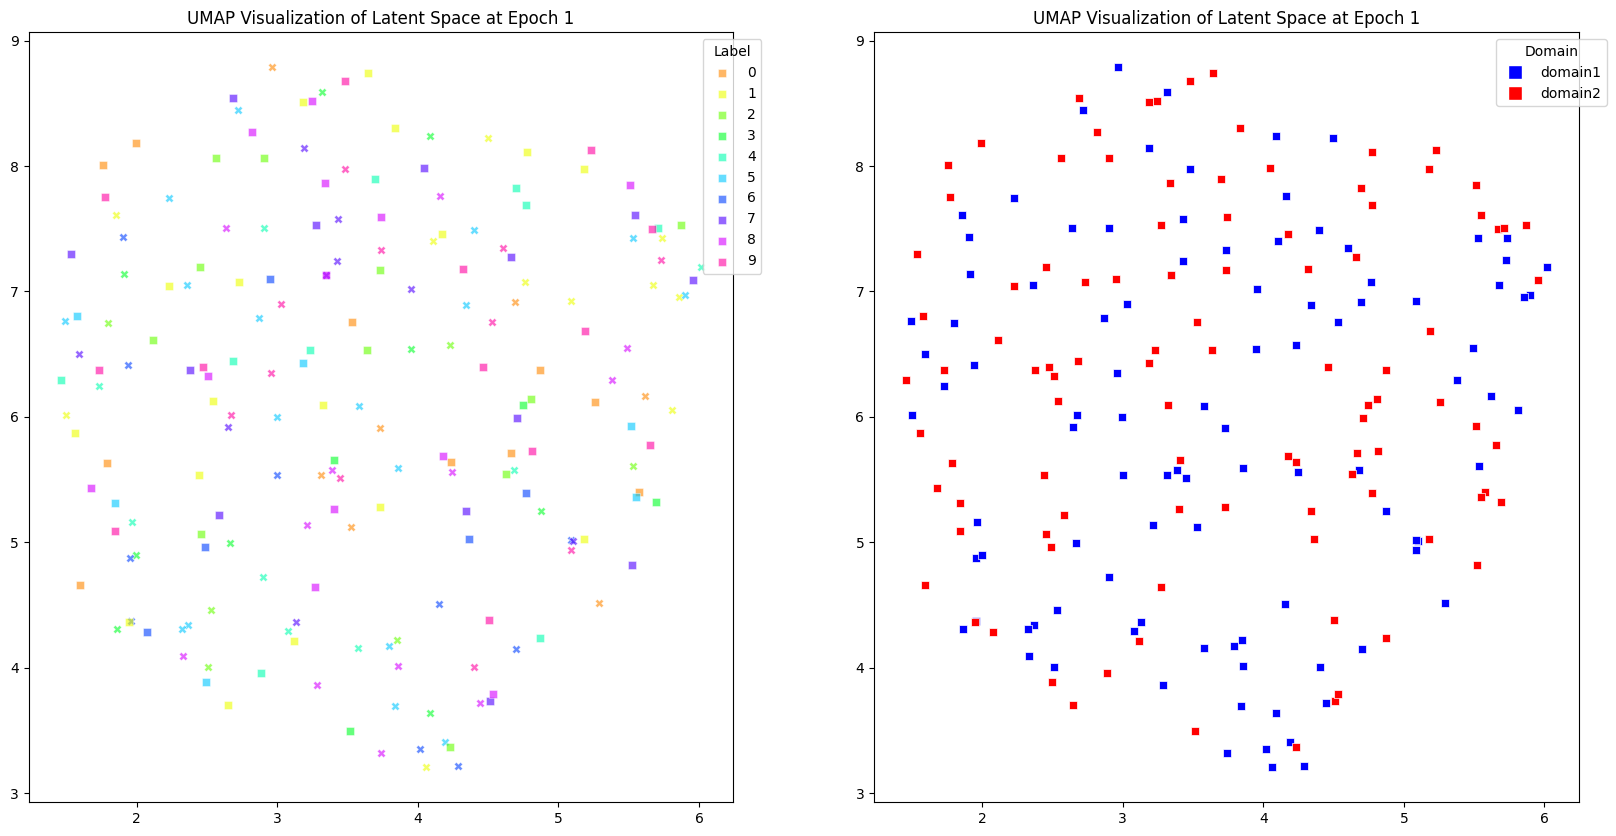

In [15]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def display_umap_for_latent(axes, epoch, z1, z2, label_1, label_2):

    # Combine the datasets
    data = np.vstack((z1, z2))
    labels = np.concatenate((label_1, label_2))
    domains = np.concatenate((['domain1'] * len(z1), ['domain2'] * len(z2)))

    # Fit and transform the data using UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(data)

    # Create a DataFrame for easier handling
    df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df['label'] = labels
    df['domain'] = domains

    # Define markers and colors
    colors = {'domain1': 'b', 'domain2': 'r'}
    unique_labels = np.unique(labels)
    palette = sns.color_palette("hsv", len(unique_labels))
    color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

    # Plot the data on the second axis (domains)
    for domain in colors:
        subset = df[df['domain'] == domain]
        axes[1].scatter(subset['UMAP1'], subset['UMAP2'], c=[colors[domain]], marker="s",
                        alpha=1, edgecolors='w', linewidth=0.5, label=f'{domain}')

    # Create a combined legend for the second plot (domains)
    axes[1].set_title(f'UMAP Visualization of Latent Space at Epoch {epoch}')
    domain_handles, domain_labels = axes[1].get_legend_handles_labels()
    unique_domains = np.unique(domains)
    domain_colors = [colors[domain] for domain in unique_domains]
    domain_legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=domain) for domain, color in zip(unique_domains, domain_colors)]
    axes[1].legend(handles=domain_legend_elements, title='Domain', loc='best', bbox_to_anchor=(1.05, 1))

    # Define distinct markers for domains on the first axis (labels)
    markers = {'domain1': 'X', 'domain2': 's'}

    # Plot the data on the first axis (labels)
    for domain in markers:
        for label in unique_labels:
            subset = df[(df['domain'] == domain) & (df['label'] == label)]
            axes[0].scatter(subset['UMAP1'], subset['UMAP2'], c=[color_map[label]], marker=markers[domain], alpha=0.6,
                            edgecolors='w', linewidth=0.5, label=f'{label}')

    # Create a combined legend for the first plot (labels)
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[0].legend(by_label.values(), by_label.keys(), title='Label', loc='best', bbox_to_anchor=(1.05, 1))

    axes[0].set_title(f'UMAP Visualization of Latent Space at Epoch {epoch}')

    return axes

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

data1 = np.random.rand(100, 10)
labels1 = np.random.randint(0, 10, 100)
domain1 = np.array(['domain1'] * 100)

data2 = np.random.rand(100, 10)
labels2 = np.random.randint(0, 10, 100)
domain2 = np.array(['domain2'] * 100)

plt_umap = display_umap_for_latent(
    axes=axes,
    epoch=1,
    z1=data1,
    z2=data2,
    label_1=labels1,
    label_2=labels2
)
plt.show()
